# Minplus algebra experiment

This code attempts to learn the 32D mixture prior
$J(x) = min(\frac{1}{2t\sigma_{1}}||x-\mu_{1}||^{2}, \frac{1}{2\sigma_{2}}||x-\mu_{2}||^{2})$
assuming we have access to training data $\{y_i, S(y_i)\} = min_{x \in \R} \ \{0.5||x-y_i||^{2}_{2} + J(x)\}\}$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/minplus_32D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the solution S(y,t) of the Hamilton--Jacobi
    PDE for the minplus algebra example at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        hjsol:  An n-dimensional numpy array of numbers
    '''

    val1 = 0.5*pow(euclid_norm(y-mu1),2)/(1+sigma1)
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/(1+sigma2)
    hjsol = np.minimum(val1,val2)
    return hjsol


def prior_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the initial data of the Hamilton--Jacobi
    PDE for the minplus algebra example.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        prior:  An n-dimensional numpy array of numbers
    '''
        
    val1 = 0.5*pow(euclid_norm(y-mu1),2)/sigma1
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/sigma2
    prior = np.minimum(val1,val2)
    return prior


def cvx_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes 0.5*norm(y)_{2}^{2} - S(y,t) at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        cvx:  An n-dimensional numpy array of numbers
    '''

    cvx = 0.5*pow(euclid_norm(y),2) - hjsol_true(y,mu1,mu2,sigma1,sigma2)
    return cvx


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_cvx_true = cvx_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    x1_0_prior_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_prior_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.subplots()
    plt.plot(xi, x1_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x1_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the convex function")
    plt.xlabel('$x_1$')
    plt.ylabel('Convex functions ($x_1$,0)')
    plt.legend()

    plt.subplots()
    plt.plot(xi, x2_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x2_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the convex function")
    plt.xlabel('$x_2$')
    plt.ylabel('Convex functions (0, $x_2$)')
    plt.legend()

    # Plot cross sections of the prior function
    plt.subplots()
    plt.plot(xi, x1_0_prior_est, "-", label="LPN")
    plt.plot(xi, x1_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the prior function")
    plt.xlabel('$x_1$')
    plt.ylabel('Prior functions ($x_1$,0)')
    plt.legend()

    plt.subplots()
    plt.plot(xi, x2_0_prior_est, "-", label="LPN")
    plt.plot(xi, x2_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the prior function")
    plt.xlabel('$x_2$')
    plt.ylabel('Prior functions (0, $x_2$)')
    plt.legend()




def plot_all(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 32

# Prior parameters
mu1 = np.zeros(dim); mu1[0] = 1.0;  sigma1 = 1.0
mu2 = np.ones(dim)/np.sqrt(dim);    sigma2 = 1.0

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 40000
Iterations = 500000

# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 5       # beta of softplus
hidden = 200     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,mu1,mu2,sigma1,sigma2).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-3
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 1925.10595703125
iteration 0 loss 344.8677062988281


iteration 5000 loss 0.22070790827274323


iteration 10000 loss 0.0945577472448349


iteration 15000 loss 0.06259922683238983


iteration 20000 loss 0.046332161873579025


iteration 25000 loss 0.03709452226758003


iteration 30000 loss 0.030896294862031937


iteration 35000 loss 0.026746410876512527


iteration 40000 loss 0.02374165505170822


iteration 45000 loss 0.02120751515030861


iteration 50000 loss 0.01922687329351902


iteration 55000 loss 0.01728876866400242


iteration 60000 loss 0.015860576182603836


iteration 65000 loss 0.014762002043426037


iteration 70000 loss 0.470558762550354


iteration 75000 loss 0.013286466710269451


iteration 80000 loss 0.012473092414438725


iteration 85000 loss 0.012096196413040161


iteration 90000 loss 0.011175626888871193


iteration 95000 loss 0.011430921964347363


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.6708366870880127


iteration 105000 loss 0.009741155430674553


iteration 110000 loss 0.009299147874116898


iteration 115000 loss 0.008929217234253883


iteration 120000 loss 0.008749383501708508


iteration 125000 loss 0.008309800177812576


iteration 130000 loss 0.008046860806643963


iteration 135000 loss 0.00780401611700654


iteration 140000 loss 0.007577157579362392


iteration 145000 loss 0.007366230711340904


iteration 150000 loss 0.007168137934058905


iteration 155000 loss 0.006983953528106213


iteration 160000 loss 0.0068116020411252975


iteration 165000 loss 0.006661473773419857


iteration 170000 loss 0.006496812216937542


iteration 175000 loss 0.006350899580866098


iteration 180000 loss 0.0062124175019562244


iteration 185000 loss 0.0060836272314190865


iteration 190000 loss 0.005961289629340172


iteration 195000 loss 0.00584391038864851


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.005734963342547417


iteration 205000 loss 0.005666118115186691


iteration 210000 loss 0.005561936181038618


iteration 215000 loss 0.005464183632284403


iteration 220000 loss 0.00537147605791688


iteration 225000 loss 0.005282951053231955


iteration 230000 loss 0.005197325721383095


iteration 235000 loss 0.005116424988955259


iteration 240000 loss 0.005036947317421436


iteration 245000 loss 0.004961301106959581


iteration 250000 loss 0.004889472853392363


iteration 255000 loss 0.004817442502826452


iteration 260000 loss 0.0047505758702754974


iteration 265000 loss 0.004684517625719309


iteration 270000 loss 0.0046201725490391254


iteration 275000 loss 0.004558177199214697


iteration 280000 loss 0.004498032853007317


iteration 285000 loss 0.004440746735781431


iteration 290000 loss 0.004384774714708328


iteration 295000 loss 0.004330255091190338


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.004277885891497135


iteration 305000 loss 0.004259472247213125


iteration 310000 loss 0.00418486911803484


iteration 315000 loss 0.004108509048819542


iteration 320000 loss 0.004035236779600382


iteration 325000 loss 0.003965575248003006


iteration 330000 loss 0.003898043418303132


iteration 335000 loss 0.003832167712971568


iteration 340000 loss 0.0037701986730098724


iteration 345000 loss 0.003709864802658558


iteration 350000 loss 0.0036521952133625746


iteration 355000 loss 0.003595852991566062


iteration 360000 loss 0.003542827907949686


iteration 365000 loss 0.0034913986455649137


iteration 370000 loss 0.003443042980507016


iteration 375000 loss 0.0033971434459090233


iteration 380000 loss 0.003351129125803709


iteration 385000 loss 0.003307830076664686


iteration 390000 loss 0.0032636169344186783


iteration 395000 loss 0.003221635241061449


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.0031806020997464657


iteration 405000 loss 0.003169040661305189


iteration 410000 loss 0.003150717820972204


iteration 415000 loss 0.003132937243208289


iteration 420000 loss 0.0031155503820627928


iteration 425000 loss 0.0030984869226813316


iteration 430000 loss 0.003081702394410968


iteration 435000 loss 0.0030651723500341177


iteration 440000 loss 0.003048872807994485


iteration 445000 loss 0.0030328035354614258


iteration 450000 loss 0.003016946604475379


iteration 455000 loss 0.003001290140673518


iteration 460000 loss 0.002985825762152672


iteration 465000 loss 0.002970555331557989


iteration 470000 loss 0.0029554679058492184


iteration 475000 loss 0.002940550446510315


iteration 480000 loss 0.002925796201452613


iteration 485000 loss 0.0029112016782164574


iteration 490000 loss 0.0028967666439712048


iteration 495000 loss 0.002882481785491109


L2 loss -- Plot

loss -7.428252696990967


loss -121.08143615722656


loss -198.27377319335938


loss -262.64373779296875


loss -316.2342529296875


loss -360.71881103515625


loss -397.4638366699219


loss -427.64984130859375


loss -452.2790222167969


loss -472.16302490234375


loss -487.96337890625


loss -500.24560546875


loss -509.5240783691406


loss -516.2907104492188


loss -521.0230712890625


loss -524.1748046875


loss -526.15771484375


loss -527.3247680664062


loss -527.959228515625


loss -528.2716674804688


loss -528.4071044921875


loss -528.4564819335938


loss -528.4705810546875


loss -528.4734497070312


loss -528.473876953125


loss -528.473876953125


loss -528.473876953125


loss -528.473876953125


loss -528.473876953125


loss -528.473876953125


loss -528.473876953125


loss -528.473876953125


loss -528.473876953125


loss -528.473876953125


loss -528.473876953125


loss -528.473876953125


loss -528.473876953125


loss -528.473876953125


loss -528.473876953125


loss -528.473876953125


final mse:  4.465731118230565e-10
max, min: 6.6952453 -7.8612194
loss -7.428252696990967


loss -121.63497161865234


loss -200.0734405517578


loss -266.72222900390625


loss -323.4853820800781


loss -371.6551513671875


loss -412.2567138671875


loss -446.2331237792969


loss -474.45587158203125


loss -497.6877136230469


loss -516.58056640625


loss -531.7035522460938


loss -543.578369140625


loss -552.69677734375


loss -559.5159912109375


loss -564.4503173828125


loss -567.8726806640625


loss -570.1199951171875


loss -571.4946899414062


loss -572.26171875


loss -572.64111328125


loss -572.8010864257812


loss -572.8556518554688


loss -572.8696899414062


loss -572.8721923828125


loss -572.8724975585938


loss -572.8724365234375


loss -572.8724365234375


loss -572.8724975585938


loss -572.8724365234375


loss -572.8724365234375


loss -572.8724975585938


loss -572.8724365234375


loss -572.8724365234375


loss -572.8724365234375


loss -572.8724975585938


loss -572.8724365234375


loss -572.8724365234375


loss -572.8724365234375


loss -572.8724975585938


final mse:  3.59260565740982e-10
max, min: 7.955024 -8.227581


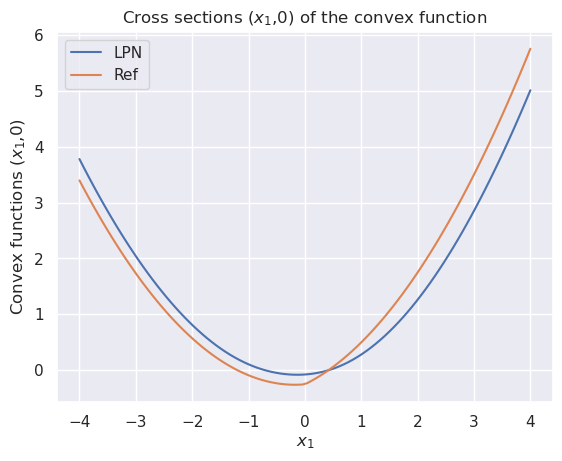

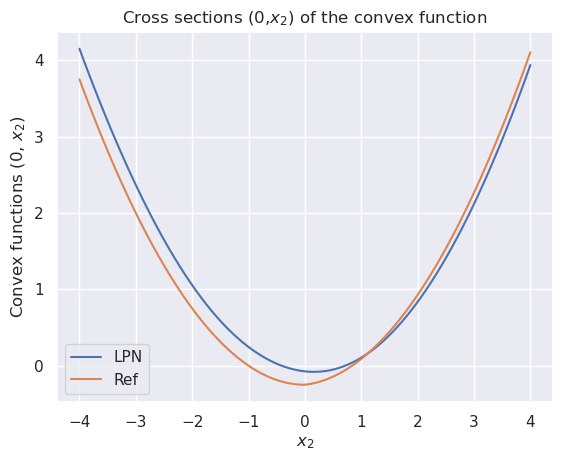

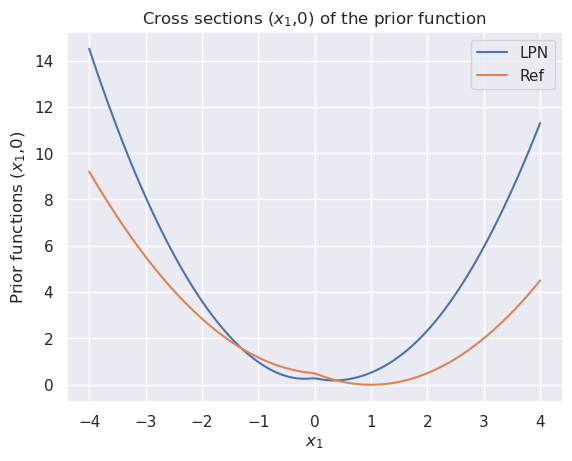

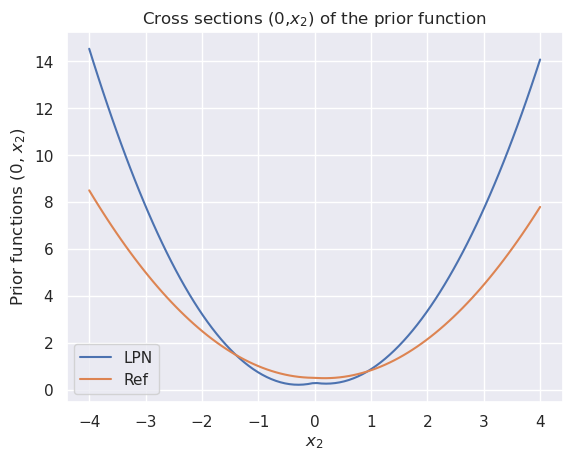

In [7]:
plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# 1. Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# 2. Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

# Detach the tensor to treat G_k as fixed targets, breaking the connection
# to the first LPN's graph and preventing the RuntimeError during training.
G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

# The input tensor x_k_tensor is still needed for the second LPN training,
# but it should also not require a gradient for that training.
x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)
# G_samples_tensor now holds the target values G_k
print(f"Generated G samples: G_samples_tensor shape {G_samples_tensor.shape}")

# --- Step 3: Train LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
# The target for this LPN is G_samples_tensor
# The input for this LPN is x_k_tensor
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-4)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")

Generated G samples: G_samples_tensor shape torch.Size([40000, 1])

--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 1737.9407958984375
iteration 0 loss 756.0752563476562


iteration 5000 loss 7.593686580657959


iteration 10000 loss 0.3691757619380951


iteration 15000 loss 0.14657773077487946


iteration 20000 loss 0.0984964445233345


iteration 25000 loss 0.07748091220855713


iteration 30000 loss 0.06478729099035263


iteration 35000 loss 0.05643754079937935


iteration 40000 loss 0.050170496106147766


iteration 45000 loss 0.04533633962273598


iteration 50000 loss 0.04127460718154907


iteration 55000 loss 0.037623610347509384


iteration 60000 loss 0.03451138362288475


iteration 65000 loss 0.04323650896549225


iteration 70000 loss 0.029758606106042862


iteration 75000 loss 0.027650011703372


iteration 80000 loss 0.025981508195400238


iteration 85000 loss 0.024609532207250595


iteration 90000 loss 0.023241832852363586


iteration 95000 loss 0.022003699094057083


Learning rate decreased to 1e-05 at iteration 100000
iteration 100000 loss 0.020929185673594475


iteration 105000 loss 0.02026670053601265


iteration 110000 loss 0.01942366361618042


iteration 115000 loss 0.01852494478225708


iteration 120000 loss 0.017783300951123238


iteration 125000 loss 0.01707841455936432


iteration 130000 loss 0.016359131783246994


iteration 135000 loss 0.015766622498631477


iteration 140000 loss 0.015232519246637821


iteration 145000 loss 0.01468923594802618


iteration 150000 loss 0.014255502261221409


iteration 155000 loss 0.01380193792283535


iteration 160000 loss 0.013386774808168411


iteration 165000 loss 0.013065840117633343


iteration 170000 loss 0.01268028188496828


iteration 175000 loss 0.012322316877543926


iteration 180000 loss 0.011978757567703724


iteration 185000 loss 0.011703874915838242


iteration 190000 loss 0.011424734257161617


iteration 195000 loss 0.011149476282298565


Learning rate decreased to 1.0000000000000002e-06 at iteration 200000
iteration 200000 loss 0.010924285277724266


iteration 205000 loss 0.010842313058674335


iteration 210000 loss 0.01051304955035448


iteration 215000 loss 0.010183744132518768


iteration 220000 loss 0.009874165058135986


iteration 225000 loss 0.009582405909895897


iteration 230000 loss 0.009309611283242702


iteration 235000 loss 0.009057640098035336


iteration 240000 loss 0.008816846646368504


iteration 245000 loss 0.00858757272362709


iteration 250000 loss 0.008367767557501793


iteration 255000 loss 0.008161398582160473


iteration 260000 loss 0.007964495569467545


iteration 265000 loss 0.007778805214911699


iteration 270000 loss 0.0075989034958183765


iteration 275000 loss 0.007427018601447344


iteration 280000 loss 0.007263415493071079


iteration 285000 loss 0.007107119541615248


iteration 290000 loss 0.0069587756879627705


iteration 295000 loss 0.0068191601894795895


Learning rate decreased to 1.0000000000000002e-07 at iteration 300000
iteration 300000 loss 0.006690327078104019


iteration 305000 loss 0.0066667660139501095


iteration 310000 loss 0.006625334732234478


iteration 315000 loss 0.0065853833220899105


iteration 320000 loss 0.00654681446030736


iteration 325000 loss 0.0065092830918729305


iteration 330000 loss 0.006472552195191383


iteration 335000 loss 0.006436532363295555


iteration 340000 loss 0.00640113977715373


iteration 345000 loss 0.006366305984556675


iteration 350000 loss 0.006331996060907841


iteration 355000 loss 0.006298166699707508


iteration 360000 loss 0.006264800205826759


iteration 365000 loss 0.0062318588607013226


iteration 370000 loss 0.006199323572218418


iteration 375000 loss 0.006167186424136162


iteration 380000 loss 0.006135426927357912


iteration 385000 loss 0.006104020401835442


iteration 390000 loss 0.006072957534343004


iteration 395000 loss 0.006042231805622578


Learning rate decreased to 1.0000000000000004e-08 at iteration 400000
iteration 400000 loss 0.006011816207319498


iteration 405000 loss 0.006008761469274759


iteration 410000 loss 0.006005678325891495


iteration 415000 loss 0.006002642679959536


iteration 420000 loss 0.005999650806188583


iteration 425000 loss 0.00599668500944972


iteration 430000 loss 0.005993736907839775


iteration 435000 loss 0.0059908065013587475


iteration 440000 loss 0.00598790030926466


iteration 445000 loss 0.005985001102089882


iteration 450000 loss 0.00598212331533432


iteration 455000 loss 0.005979266483336687


iteration 460000 loss 0.0059764189645648


iteration 465000 loss 0.0059735835529863834


iteration 470000 loss 0.005970765370875597


iteration 475000 loss 0.005967956967651844


iteration 480000 loss 0.0059651597402989864


iteration 485000 loss 0.005962372291833162


iteration 490000 loss 0.005959596950560808


iteration 495000 loss 0.005956835579127073


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


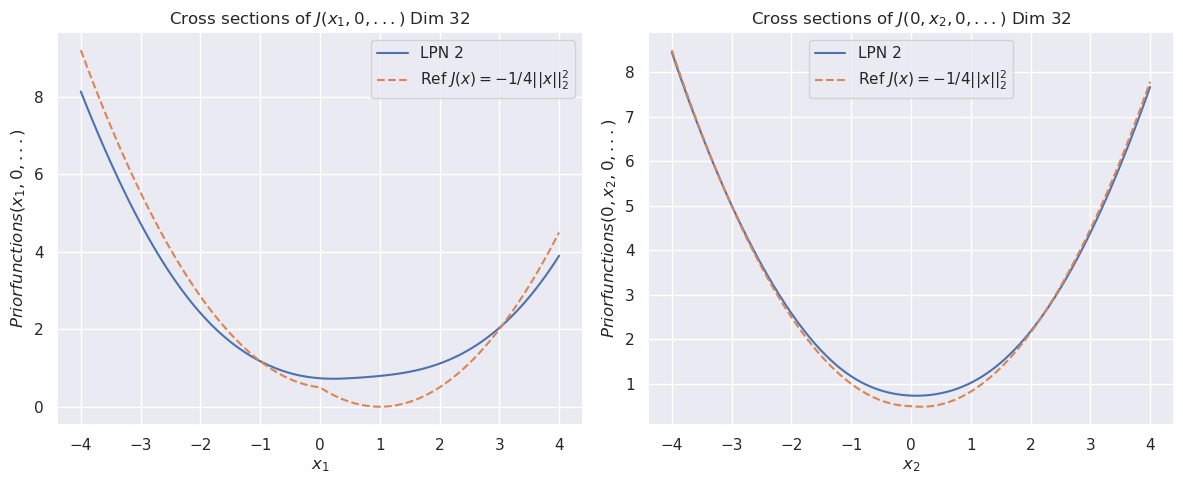

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    # Get G(x) from the second LPN model
    G_x = model_G.scalar(x_tensor)
    
    # Compute 0.5 * ||x||^2
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim,mu1,mu2,sigma1,sigma2):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Prior functions (x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Prior functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    #plt.savefig('G_network_prior_plot.png')
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim,mu1,mu2,sigma1,sigma2)